In [2]:
import casadi as ca
from lib.cartpolesystem import CartPoleStepperMotorSystem
from lib.motors import StepperMotor
from lib.cartpolesystem import Cart, Pole
from lib.cartpoleenv import CartPoleEnv
from lib.numerical import rk4_step
import numpy as np
from numpy import radians
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from lib.controllers import LQR
from time import perf_counter

In [3]:
dt = 0.01
g = 9.81

cart = Cart(0.1, 0.01, (-0.8, 0.8), 0.2)
motor = StepperMotor(0.05, (-10, 10), 0.2, (-10, 10), 0.2)
poles = [Pole(0.1, 0.15, 0.01), Pole(0.3, 0.2, 0.01)]
n = len(poles)

system = CartPoleStepperMotorSystem(cart, motor, poles, g)

max_time = 10
N_env = int(max_time/dt)

env = CartPoleEnv(system, dt, N_env, rk4_step)
env.observation_space.shape

(6,)

In [4]:
end_time = 4
dt_collocation = 0.05
N_collocation = int(end_time/dt_collocation)+1
h = end_time/N_collocation
# h = dt_collocation

N = int(end_time/dt)

opti = ca.Opti()

xs = opti.variable(N_collocation,system.num_states)
us = opti.variable(N_collocation,system.num_controls)

x0 = np.array([0, 0] + [radians(180), 0]*n)
r = np.array([0, 0] + [0, 0]*n)

In [5]:
opti.subject_to(xs[0,0] == x0[0])
opti.subject_to(xs[-1,0] == r[0])
opti.subject_to(xs[0,1] == x0[1])
opti.subject_to(xs[-1,1] == r[1])

for i in range(system.num_poles*2):
    if i % 2 == 0:
        opti.subject_to(ca.arctan2(ca.sin(x0[i+2]-xs[0,i+2]),ca.cos(x0[i+2]-xs[0,i+2])) == 0)
        opti.subject_to(ca.arctan2(ca.sin(r[i+2]-xs[-1,i+2]),ca.cos(r[i+2]-xs[-1,i+2])) == 0)
    else:
        opti.subject_to(xs[0,i+2] == x0[i+2])
        opti.subject_to(xs[-1,i+2] == r[i+2])
print(opti)

Opti {
  instance #0
  #variables: 1 (nx = 486)
  #parameters: 0 (np = 0)
  #constraints: 12 (ng = 12)
  CasADi solver needs updating.
}


In [6]:
obj = 0
for i in range(N_collocation-1):
    obj += (us[i,0]**2+us[i+1,0]**2)*h/2
opti.minimize(obj)
print("Obj:", obj)
# opti.minimize(ca.sumsqr(us))

Obj: (((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((0.0493827*(sq(opti0_x_2[0])+sq(opti0_x_2[1])))/2)+((0.0493827*(sq(opti0_x_2[1])+sq(opti0_x_2[2])))/2))+((0.0493827*(sq(opti0_x_2[2])+sq(opti0_x_2[3])))/2))+((0.0493827*(sq(opti0_x_2[3])+sq(opti0_x_2[4])))/2))+((0.0493827*(sq(opti0_x_2[4])+sq(opti0_x_2[5])))/2))+((0.0493827*(sq(opti0_x_2[5])+sq(opti0_x_2[6])))/2))+((0.0493827*(sq(opti0_x_2[6])+sq(opti0_x_2[7])))/2))+((0.0493827*(sq(opti0_x_2[7])+sq(opti0_x_2[8])))/2))+((0.0493827*(sq(opti0_x_2[8])+sq(opti0_x_2[9])))/2))+((0.0493827*(sq(opti0_x_2[9])+sq(opti0_x_2[10])))/2))+((0.0493827*(sq(opti0_x_2[10])+sq(opti0_x_2[11])))/2))+((0.0493827*(sq(opti0_x_2[11])+sq(opti0_x_2[12])))/2))+((0.0493827*(sq(opti0_x_2[12])+sq(opti0_x_2[13])))/2))+((0.0493827*(sq(opti0_x_2[13])+sq(opti0_x_2[14])))/2))+((0.0493827*(sq(opti0_x_2[14])+sq(opti0_x_2[15])))/2))+((0.0493827*(sq(opti0_x_2[15])+sq(opti0_x_2[16])))/2))+((0.0493827*(sq(opti0_x_2[16])+sq(opti0_x_2[17])))/2))+(

In [7]:
last_x = [None for _ in range(system.num_states)]
last_d_x = [None for _ in range(1+system.num_poles)]
first = True
for i in range(N_collocation):
    s = xs[i,0]
    d_s = xs[i,1]
    dd_s = us[i,0]
    opti.subject_to(opti.bounded(system.state_lower_bound[0]+system.state_margin[0],s,system.state_upper_bound[0]-system.state_margin[0]))
    opti.subject_to(opti.bounded(system.state_lower_bound[1]+system.state_margin[1],d_s,system.state_upper_bound[1]-system.state_margin[1]))
    sum1 = 0
    sum2 = 0
    sum3 = 0
    sum4 = 0
    
    if not first:
        last_s = last_x[0]
        last_d_s = last_x[1]
        last_dd_s = last_d_x[0]
        opti.subject_to((d_s+last_d_s)*h/2 == (s-last_s)) 
        opti.subject_to((dd_s+last_dd_s)*h/2 == (d_s-last_s)) 
    last_x[0] = s
    last_x[1] = d_s
    last_d_x[0] = dd_s
    for j in range(system.num_poles):
        theta = xs[i,2+2*j]
        d_theta = xs[i,3+2*j]
        l = system.ls[j]
        m = system.ms[j]
        u_p = system.u_ps[j]
        dd_theta = 3/(7*l/2)*(system.g*ca.sin(theta)-dd_s*ca.cos(theta)-u_p*d_theta/(m*l/2))
        sum1 += m*ca.sin(theta)*ca.cos(theta)
        sum2 += m*l/2*d_theta**2*ca.sin(theta)
        sum3 += u_p*d_theta*ca.cos(theta)/(l/2)
        sum4 += m*ca.cos(theta)**2
        if not first:
            last_theta = last_x[2+2*j]
            last_d_theta = last_x[3+2*j]
            last_dd_theta = last_d_x[1+j]
            opti.subject_to((d_theta+last_d_theta)*h/2 == (theta-last_theta))
            opti.subject_to((dd_theta+last_dd_theta)*h/2 == (d_theta-last_d_theta))
        last_x[2+2*j] = theta
        last_x[3+2*j] = d_theta
        last_d_x[1+j] = dd_theta
    f = 3/7*(system.g*sum1-7/3*(sum2-system.cart.u_c*d_s)-sum3-(sum4-7/3*system.M)*dd_s)
    torque = f*system.motor.r
    opti.subject_to(opti.bounded(system.motor.torque_bounds[0]*(1-system.motor.torque_margin),torque,system.motor.torque_bounds[1]*(1-system.motor.torque_margin)))
    first = False
        

In [8]:
x_guess = np.linspace(x0, r, N_collocation)
u_guess = np.zeros((N_collocation, system.num_controls))

opti.set_initial(xs, x_guess)
opti.set_initial(us, u_guess)
opti

Opti(Opti {
  instance #0
  #variables: 2 (nx = 567)
  #parameters: 0 (np = 0)
  #constraints: 735 (ng = 735)
  CasADi solver needs updating.
})

In [9]:
opti.solver("ipopt")
sol = opti.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     2252
Number of nonzeros in inequality constraint Jacobian.:      648
Number of nonzeros in Lagrangian Hessian.............:      729

Total number of variables............................:      567
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      492
Total number of inequality c

In [10]:
x_optimal_raw = sol.value(xs)
u_optimal_raw = sol.value(us)

time_collocation = np.linspace(0, end_time, N_collocation)

In [11]:
N_spline_time = np.linspace(0, end_time, N)

states = np.vstack([
    CubicSpline(time_collocation, s_row)(N_spline_time) for s_row in x_optimal_raw.T
]).T
controls = np.vstack(np.interp(N_spline_time, time_collocation, u_optimal_raw))

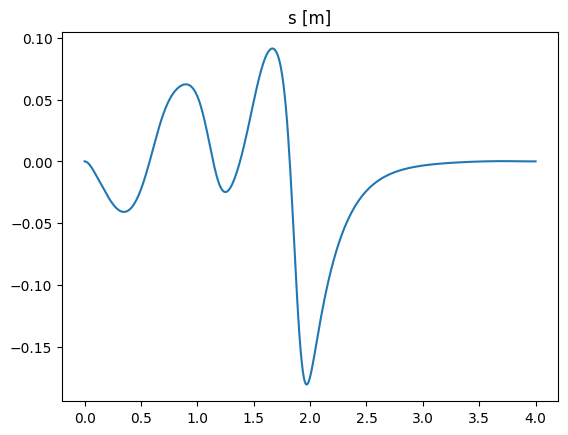

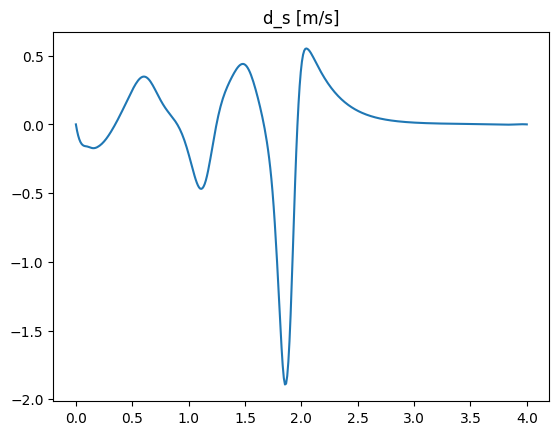

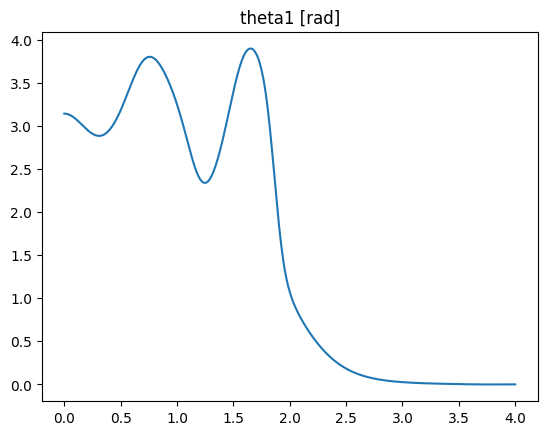

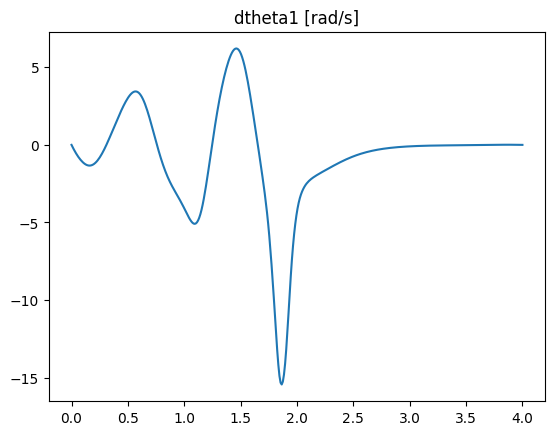

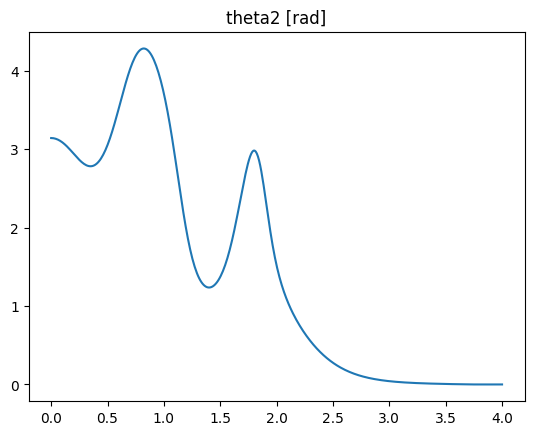

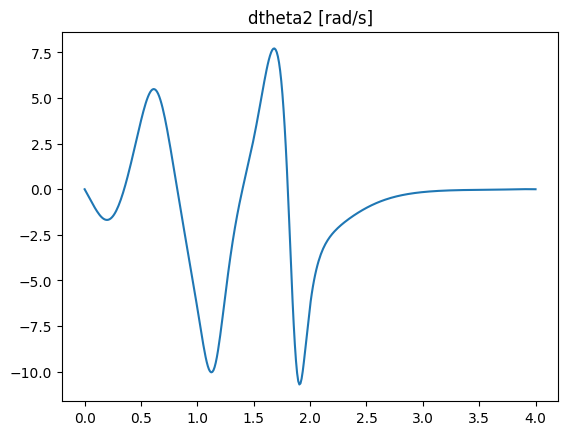

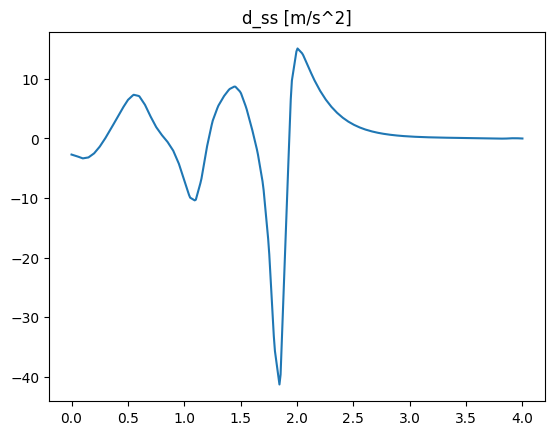

In [12]:
time = np.linspace(0, end_time, N)

labels = ["s [m]", "d_s [m/s]", "theta1 [rad]", "dtheta1 [rad/s]", "theta2 [rad]", "dtheta2 [rad/s]"]

for i in range(system.num_states):
    plt.figure()
    plt.title(labels[i])
    plt.plot(time, states[:,i])
    plt.show()

plt.title("d_ss [m/s^2]")
plt.plot(time, controls)
plt.show()

In [13]:
np.set_printoptions(precision=3)

linearization_x0 = np.zeros(2+2*n)
linearization_u0 = np.array([0])

A0, B0 = system.linearize(linearization_x0, linearization_u0)

C = np.diag([1, 1]+[1, 1]*n)

D = np.zeros((1, 1))

ct_dt = dt

lqr = LQR(ct_dt)

Q = np.diag([10, 1]+[100, 1]*n)
R = np.diag([10])

A_d0, B_d0 = lqr.discretize(A0, B0, C, D)
K_d0 = lqr.calculate_K_d(A_d0, B_d0, Q, R)

print("A:", A0)
print("B:", B0)

A: [[ 0.     1.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     1.     0.     0.   ]
 [ 0.     0.    56.057 -7.619  0.     0.   ]
 [ 0.     0.     0.     0.     0.     1.   ]
 [ 0.     0.     0.     0.    42.043 -1.429]]
B: [[ 0.   ]
 [ 1.   ]
 [ 0.   ]
 [-5.714]
 [ 0.   ]
 [-4.286]]


In [14]:
print("Calculating As and Bs...")
As, Bs = np.vectorize(system.linearize, signature='(n),(m)->(n,n),(n,m)')(states, controls)

Calculating As and Bs...


In [15]:
print("Calculating A_ds and B_ds...")
A_ds, B_ds = np.vectorize(lqr.discretize, signature='(n,n),(n,m),(a,b),(c,d)->(n,n),(n,m)')(As, Bs, C, D)
print("Calculating K_ds...")
_, K_ds = lqr.calculate_finite_K_ds(A_ds, B_ds, Q, R)

Calculating A_ds and B_ds...
Calculating K_ds...


In [16]:
print("Memory usage K_ds: ", (K_ds.nbytes)/1024**1, "KB")

Memory usage K_ds:  18.75 KB


In [17]:
last_update = perf_counter()

state, _ = env.reset(x0)

errors = np.zeros((N_env, 2+2*n))
feedback_controls = np.zeros((N_env, 1))

for i in range(N_env-1):
    while perf_counter() < last_update + dt:
        pass
    last_update = perf_counter()

    error = np.zeros(2+2*n)
    if i < N*1:
        error = system.calculate_error(state, states[i])
        u_ff = controls[i]
        u_fb = lqr.feedback(K_ds[i], error)
        u = u_ff + u_fb
        feedback_controls[i] = u_fb
    else:
        error = system.calculate_error(state, states[-1])
        u = lqr.feedback(K_ds[-1], error)
    errors[i] = error

    state, reward, done, msg, _ = env.step(u)
    env.render()

env.close()

c:\Users\sacka\Documents\programming\projects\inverted-pendulum\src\python\lib\cartpolesystem.py:248: RuntimeWarning: overflow encountered in square
  sum2 = sum(self.ms*(self.ls/2)*d_thetas**2*sin(thetas))
c:\Users\sacka\Documents\programming\projects\inverted-pendulum\src\python\lib\cartpolesystem.py:248: RuntimeWarning: invalid value encountered in double_scalars
  sum2 = sum(self.ms*(self.ls/2)*d_thetas**2*sin(thetas))
c:\Users\sacka\Documents\programming\projects\inverted-pendulum\src\python\lib\cartpolesystem.py:219: RuntimeWarning: overflow encountered in square
  sum2 = sum(self.ms*(self.ls/2)*d_thetas**2*sin(thetas))
c:\Users\sacka\Documents\programming\projects\inverted-pendulum\src\python\lib\cartpolesystem.py:303: RuntimeWarning: invalid value encountered in subtract
  dd_thetas = 3/(7*self.ls/2)*(self.g*sin(thetas)-dd_s*cos(thetas)-self.u_ps*d_thetas/(self.ms*self.ls/2))
c:\Users\sacka\Documents\programming\projects\inverted-pendulum\src\python\lib\cartpolesystem.py:303: R

ValueError: cannot convert float NaN to integer

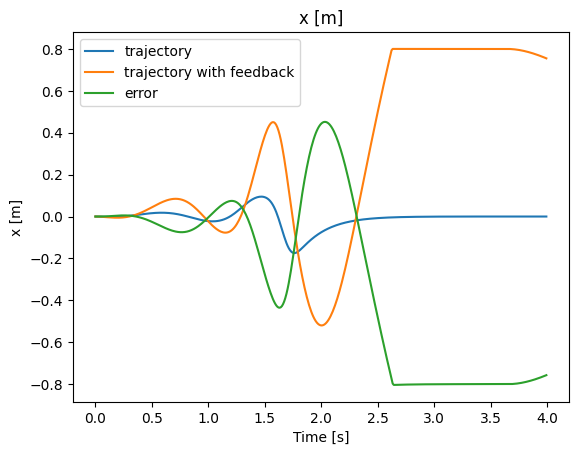

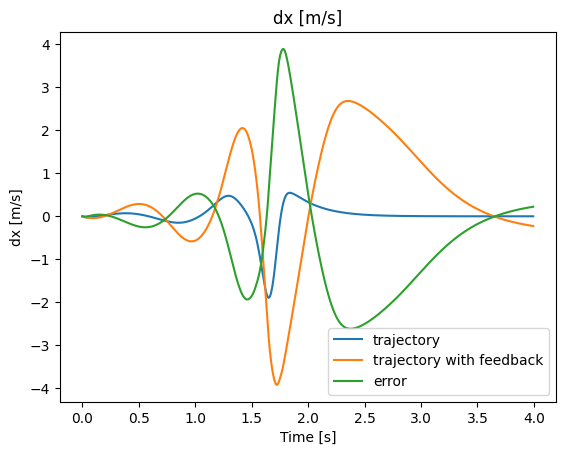

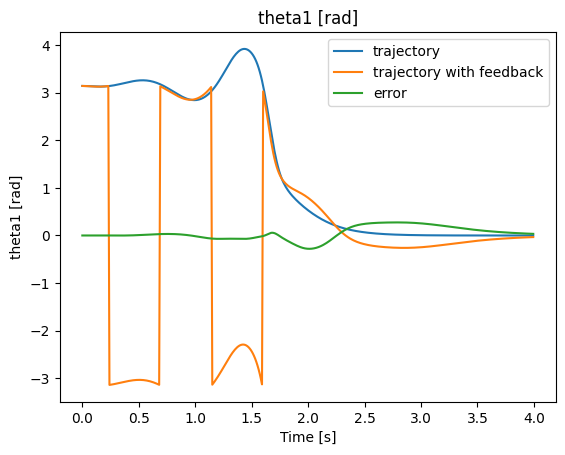

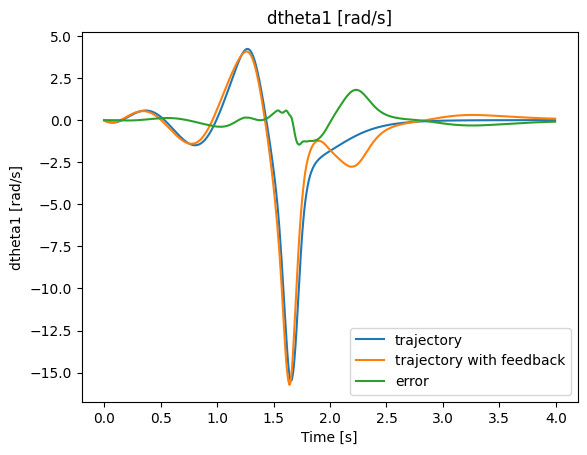

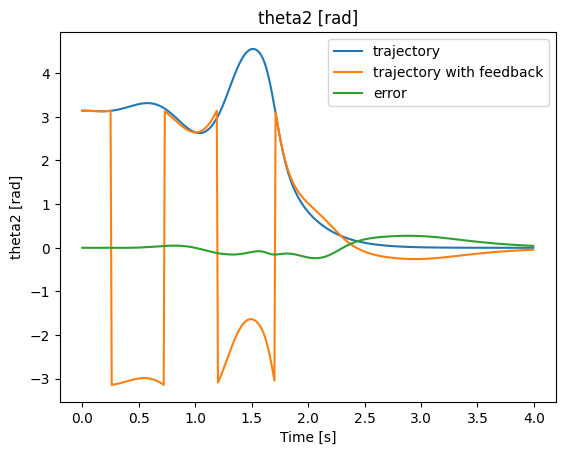

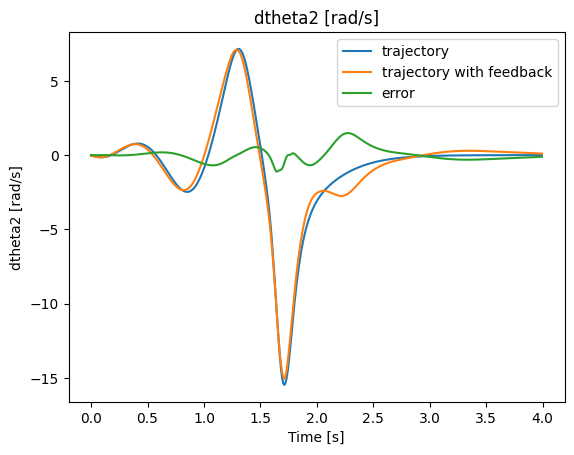

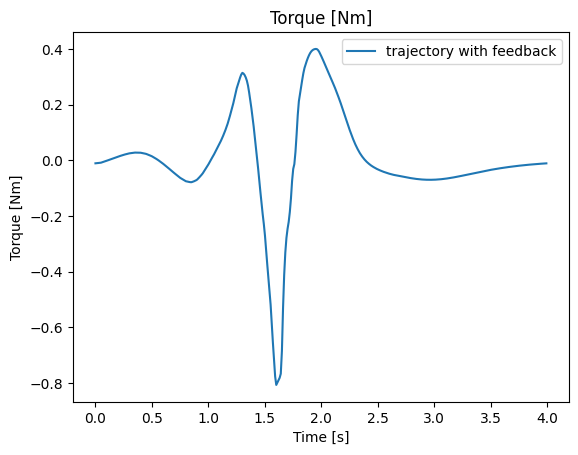

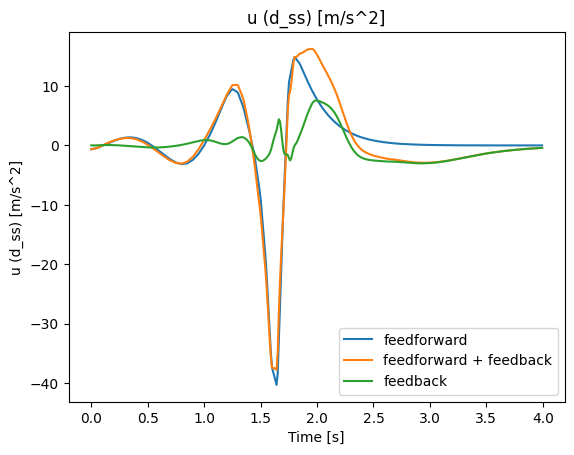

In [ ]:
time = np.linspace(0, max_time, N_env)
state_labels = ["x [m]", "dx [m/s]", "theta1 [rad]", "dtheta1 [rad/s]", "theta2 [rad]", "dtheta2 [rad/s]", "theta3 [rad]", "dtheta3 [rad/s"]
for i in range(system.num_states):
    plt.xlabel("Time [s]")
    plt.ylabel(state_labels[i])
    plt.title(state_labels[i])
    plt.plot(time[:N], states.T[i][:N], label="trajectory")
    plt.plot(time[:N], env.states.T[i][1:N+1], label="trajectory with feedback")
    plt.plot(time[:N], errors.T[i][:N], label="error")
    plt.legend()
    plt.show()

constrain_labels = ["Torque [Nm]"]
for i in range(system.num_constraint_states):
    plt.xlabel("Time [s]")
    plt.ylabel(constrain_labels[i])
    plt.title(constrain_labels[i])
    plt.plot(time[:N], env.constraint_states.T[i][1:N+1], label="trajectory with feedback")
    plt.legend()
    plt.show()

plt.title("u (d_ss) [m/s^2]")
plt.xlabel("Time [s]")
plt.ylabel("u (d_ss) [m/s^2]")
plt.plot(time[:N], controls.T[0][:N], label="feedforward")
plt.plot(time[:N], env.controls.T[0][1:N+1], label="feedforward + feedback")
plt.plot(time[:N], feedback_controls.T[0][:N], label="feedback")
plt.legend()
plt.show()